In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
os.chdir('/home/rv76/CCB/BioPlexPy/')

# data import funcs
from bioplexpy.data_import_funcs import getBioPlex
from bioplexpy.data_import_funcs import getCorum
from bioplexpy.data_import_funcs import get_UniProts_from_CORUM

## [0] Environment Setup

setup for running 
- created virtual environment in conda 
> conda create -n CCB_BioPlexPy python=3.9.12
- installed **pandas**
> conda install -c anaconda pandas
- installed **requests**
> conda install -c anaconda requests
- installed **anndata**
> conda install anndata -c bioconda
- installed **jupyter notebook**
> conda install -c conda-forge notebook
- installed **networkx**
> pip install networkx[default]
- installed **biopython**
> conda install -c conda-forge biopython
- installed **pypdb**
> pip install pypdb

## [1] *Function* to convert BioPlex PPIs into a graph data structure

In [4]:
import networkx as nx
import pandas as pd

def bioplex2graph(bp_PPI_df):
    '''
    Convert BioPlex PPIs into a graph.
    
    This function converts representation of BioPlex PPIs into a 
    graph data structure representation of BioPlex PPIs in a NetworkX 
    object from NetworkX. 

    Parameters
    ----------
    DataFrame of PPIs : Pandas DataFrame

    Returns
    -------
    NetworkX graph
        A NetworkX graph with Nodes = Uniprot Gene Symbols 
        and Edges = interactions.

    Examples
    --------
    # (1) Obtain the latest version of the 293T PPI network
    >>> bp_293t_df = getBioPlex('293T', '3.0')
    # (2) Turn the data into a graph
    >>> bp_293t_G = bioplex2graph(bp_293t_df) 
    '''
    # add isoform columns for Uniprot source & Uniprot target
    bp_PPI_df.loc[:,'isoformA'] = bp_PPI_df.UniprotA
    bp_PPI_df.loc[:,'isoformB'] = bp_PPI_df.UniprotB

    # reconstruct UniprotA/UniprotB columns without '-' isoform id
    UniprotA_new = []
    UniprotB_new = []
    for UniprotA, UniprotB in zip(bp_PPI_df.UniprotA, bp_PPI_df.UniprotB):

        if '-' in UniprotA:
            UniprotA_new.append(UniprotA.split('-')[0])
        else:
            UniprotA_new.append(UniprotA)

        if '-' in UniprotB:
            UniprotB_new.append(UniprotB.split('-')[0])
        else:
            UniprotB_new.append(UniprotB)

    # update columns for Uniprot source 
    # & Uniprot target to exclude isoform '-' ID
    bp_PPI_df.loc[:,'UniprotA'] = UniprotA_new
    bp_PPI_df.loc[:,'UniprotB'] = UniprotB_new
    
    # construct graph from BioPlex PPI data
    bp_G = nx.DiGraph()
    for source, target, pW, pNI, pInt in zip(bp_PPI_df.UniprotA, 
            bp_PPI_df.UniprotB, bp_PPI_df.pW, bp_PPI_df.pNI, bp_PPI_df.pInt):
        bp_G.add_edge(source, target, pW=pW, pNI=pNI, pInt=pInt)
        
    # get mapping uniprot -> entrez & store as node attribute
    uniprot_entrez_dict = {}
    for uniprot_A, entrez_A in zip(bp_PPI_df.UniprotA, bp_PPI_df.GeneA):
        uniprot_entrez_dict[uniprot_A] = entrez_A
    for uniprot_B, entrez_B in zip(bp_PPI_df.UniprotB, bp_PPI_df.GeneB):
        uniprot_entrez_dict[uniprot_B] = entrez_B

    for node_i in bp_G.nodes():
        bp_G.nodes[node_i]["entrezid"] = uniprot_entrez_dict[node_i]

    # get mapping uniprot -> symbol & store as node attribute
    uniprot_symbol_dict = {}
    for uniprot_A, symbol_A in zip(bp_PPI_df.UniprotA, bp_PPI_df.SymbolA):
        uniprot_symbol_dict[uniprot_A] = symbol_A
    for uniprot_B, symbol_B in zip(bp_PPI_df.UniprotB, bp_PPI_df.SymbolB):
        uniprot_symbol_dict[uniprot_B] = symbol_B

    for node_i in bp_G.nodes():
        bp_G.nodes[node_i]["symbol"] = uniprot_symbol_dict[node_i]

    # get mapping uniprot -> isoform & store as node attribute
    uniprot_isoform_dict = {}
    for uniprot_A, isoform_A in zip(bp_PPI_df.UniprotA, bp_PPI_df.isoformA):
        uniprot_isoform_dict[uniprot_A] = isoform_A
    for uniprot_B, isoform_B in zip(bp_PPI_df.UniprotB, bp_PPI_df.isoformB):
        uniprot_isoform_dict[uniprot_B] = isoform_B

    for node_i in bp_G.nodes():
        bp_G.nodes[node_i]["isoform"] = uniprot_isoform_dict[node_i]
        
    # get set of baits & store a bait boolean as node attribute 
    # if node is a bait True & False otherwise
    bp_i_baits = set(bp_PPI_df.UniprotA)
    for node_i in bp_G.nodes():
        if node_i in bp_i_baits:
            bp_G.nodes[node_i]["bait"] = True
        else:
            bp_G.nodes[node_i]["bait"] = False
    
    return bp_G

In [8]:
bp_293t_df = getBioPlex('293T', '3.0')
bp_293t_G = bioplex2graph(bp_293t_df)

In [9]:
bp_293t_df.head()

,GeneA,GeneB,UniprotA,UniprotB,SymbolA,SymbolB,pW,pNI,pInt,isoformA,isoformB
0,100,728378,P00813,A5A3E0,ADA,POTEF,6.881844e-10,0.000118,0.999882,P00813,A5A3E0
1,222389,6137,Q8N7W2,P26373,BEND7,RPL13,1.340380e-18,0.225664,0.774336,Q8N7W2-2,P26373
2,222389,5928,Q8N7W2,Q09028,BEND7,RBBP4,7.221401e-21,0.000064,0.999936,Q8N7W2-2,Q09028-3
3,222389,25873,Q8N7W2,Q9Y3U8,BEND7,RPL36,7.058372e-17,0.128183,0.871817,Q8N7W2-2,Q9Y3U8
4,222389,6124,Q8N7W2,P36578,BEND7,RPL4,1.632313e-22,0.200638,0.799362,Q8N7W2-2,P36578


construct network from list of edges, then iterate to add attributes (check runtime)

Nodes

In [17]:
len(bp_293t_G.nodes()) # number of nodes

13689

In [18]:
list(bp_293t_G.nodes())[0:5]

['P00813', 'A5A3E0', 'Q8N7W2', 'P26373', 'Q09028']

In [19]:
bp_293t_G.nodes['P00813']

{'entrezid': 100, 'symbol': 'ADA', 'isoform': 'P00813', 'bait': True}

In [20]:
bp_293t_G.nodes['Q8N7W2']

{'entrezid': 222389, 'symbol': 'BEND7', 'isoform': 'Q8N7W2-2', 'bait': True}

Edges

In [21]:
len(bp_293t_G.edges()) # number of edges

115868

In [22]:
list(bp_293t_G.edges())[0:5]

[('P00813', 'A5A3E0'),
 ('Q8N7W2', 'P26373'),
 ('Q8N7W2', 'Q09028'),
 ('Q8N7W2', 'Q9Y3U8'),
 ('Q8N7W2', 'P36578')]

In [23]:
bp_293t_G.get_edge_data('P00813', 'A5A3E0')

{'pW': 6.881843799526549e-10,
 'pNI': 0.000117635665707004,
 'pInt': 0.9998823636461089}

Algorithms on Network

pagerank

In [24]:
pr = nx.pagerank(bp_293t_G, alpha=0.8)
pr = pd.Series(pr)
pr.sort_values(ascending = False, inplace = True)

In [25]:
pr

P11142    0.002610
P11021    0.002168
Q04917    0.001840
O14556    0.001527
P0CG47    0.001471
            ...   
Q8TB92    0.000039
P07355    0.000039
Q53F39    0.000039
Q96HL8    0.000039
P00813    0.000039
Length: 13689, dtype: float64

## [2] *Function* that returns matching edges (PPI data) for a given CORUM complex as a sub-graph

In [5]:
import numpy as np

def get_PPI_network_for_complex(bp_PPI_G, Corum_DF, Complex_ID):
    '''
    Retrieve Network of BioPlex (AP-MS) PPIs for a CORUM complex.
    
    This function returns a subgraph of PPIs identified through AP-MS
    between the proteins in a specified CORUM complex.

    Parameters
    ----------
    Network of PPIs : NetworkX graph
    DataFrame of CORUM complexes : Pandas DataFrame
    Corum Complex ID: int

    Returns
    -------
    NetworkX Graph
        A subgraph induced by the proteins in a CORUM complex 
        from the BioPlex network used as input.

    Examples
    --------
    # (1) Obtain the latest version of the 293T PPI network
    >>> bp_293t_df = getBioPlex('293T', '3.0')
    # (2) Obtain NetworkX graph representation of 293T PPI network
    >>> bp_293t_G = bioplex2graph(bp_293t_df)
    # (3) Obtain CORUM complexes
    >>> Corum_DF = getCorum('core', 'Human')
    # (4) Get AP-MS interactions as subgraph for a specified 
          protein complex using PPI data
    >>> ING2_bp_293t_G = get_PPI_network_for_complex(bp_293t_G, Corum_DF, 2851)
    '''
    # store gene UNIPROT IDs that belong to this complex in a list
    genes_in_complex_i = (Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,
                                'subunits(UniProt IDs)'].values[0].split(';'))
    
    # get subgraph induced by the subset of nodes in this CORUM complex
    bp_complex_i_G = bp_PPI_G.subgraph(genes_in_complex_i)
    
    return bp_complex_i_G

In [13]:
bp_293t_df = getBioPlex('293T', '3.0')
bp_293t_G = bioplex2graph(bp_293t_df)
Corum_DF = getCorum('core', 'Human')

**ING2** complex from HEK293T cell line PPI data version 3.0

In [26]:
ING2_bp_293t_G = get_PPI_network_for_complex(bp_293t_G, Corum_DF, 2851)
len(list(ING2_bp_293t_G.edges))

51

**BCOR** complex from HEK293T cell line PPI data version 3.0

In [27]:
BCOR_bp_293t_G = get_PPI_network_for_complex(bp_293t_G, Corum_DF, 1178)
len(list(BCOR_bp_293t_G.edges))

14

## [3] *Function* that takes an AP-MS graph (NetworkX) and returns a dataframe of PPIs (Edges)

*Note* - lose info about which node is a BAIT and which node is a PREY

In [6]:
def get_DataFrame_from_PPI_network(bp_PPI_G):
    '''
    Convert Network of BioPlex (AP-MS) PPIs into DataFrame of BioPlex 
    interaction Network.
    
    This function returns a DataFrame of PPIs (identified through AP-MS) 
    represented as a graph.

    Parameters
    ----------
    Network of PPIs : NetworkX graph

    Returns
    -------
    Pandas DataFrame
        A DataFrame of edges (AP-MS interactions) from a network.

    Examples
    --------
    # (1) Obtain the latest version of the 293T PPI network
    >>> bp_293t_df = getBioPlex('293T', '3.0')
    # (2) Obtain NetworkX graph representation of 293T PPI network
    >>> bp_293t_G = bioplex2graph(bp_293t_df)
    # (3) Obtain CORUM complexes
    >>> Corum_DF = getCorum('core', 'Human')
    # (4) Get AP-MS interactions as subgraph for a specified 
          protein complex using PPI data
    >>> ING2_bp_293t_G = get_PPI_network_for_complex(bp_293t_G, Corum_DF, 2851)
    # (5) Convert ING2 AP-MS network into DataFrame w/ each 
          row corresponding to an edge
    >>> ING2_bp_293t_df = get_DataFrame_from_PPI_network(ING2_bp_293t_G)
    '''
    # get list of edges in network
    PPI_edge_list = list(bp_PPI_G.edges)

    # make node_A and node_B columns for both UNIPROT & SYMBOLS
    uniprotA_list = []
    uniprotB_list = []
    symbolA_list = []
    symbolB_list = []

    # make columns for calcs detected for each edge
    pW_list = []
    pNI_list = []
    pInt_list = []

    # iterate through each edge to store data for each row of DataFrame
    for edge_i in PPI_edge_list:

        nodeA, nodeB = edge_i

        # nodes are labeled with UNIPROT
        uniprotA_list.append(nodeA)
        uniprotB_list.append(nodeB)

        # get gene SYMBOL
        symbolA_list.append(bp_PPI_G.nodes[nodeA]['symbol'])
        symbolB_list.append(bp_PPI_G.nodes[nodeB]['symbol'])

        # get AP-MS calculations
        pW_list.append(bp_PPI_G.edges[edge_i]['pW'])
        pNI_list.append(bp_PPI_G.edges[edge_i]['pNI'])
        pInt_list.append(bp_PPI_G.edges[edge_i]['pInt'])

    # convert lists into cols of DataFrame
    bp_complex_i_df = pd.DataFrame()
    bp_complex_i_df.loc[:,'UniprotA'] = uniprotA_list
    bp_complex_i_df.loc[:,'UniprotB'] = uniprotB_list
    bp_complex_i_df.loc[:,'SymbolA'] = symbolA_list
    bp_complex_i_df.loc[:,'SymbolB'] = symbolB_list
    bp_complex_i_df.loc[:,'pW'] = pW_list
    bp_complex_i_df.loc[:,'pNI'] = pNI_list
    bp_complex_i_df.loc[:,'pInt'] = pInt_list
    
    return bp_complex_i_df

In [27]:
bp_293t_df = getBioPlex('293T', '3.0')
bp_293t_G = bioplex2graph(bp_293t_df)
Corum_DF = getCorum('core', 'Human')

**ING2** complex from HEK293T cell line PPI data version 3.0

In [30]:
ING2_bp_293t_G = get_PPI_network_for_complex(bp_293t_G, Corum_DF, 2851)
ING2_bp_293t_df = get_DataFrame_from_PPI_network(ING2_bp_293t_G)

In [31]:
ING2_bp_293t_df.head()

,UniprotA,UniprotB,SymbolA,SymbolB,pW,pNI,pInt
0,Q9H7L9,Q96ST3,SUDS3,SIN3A,1.147993e-10,5.101263e-04,0.999490
1,Q96ST3,Q16576,SIN3A,RBBP7,9.203087e-31,2.524394e-05,0.999975
2,Q96ST3,Q09028,SIN3A,RBBP4,3.786405e-30,5.092920e-05,0.999949
3,Q96ST3,Q13547,SIN3A,HDAC1,1.189159e-28,8.638251e-05,0.999914
4,Q16576,O75446,RBBP7,SAP30,3.577174e-21,1.089399e-07,1.000000


In [32]:
ING2_bp_293t_df.shape

(51, 7)

**BCOR** complex from HEK293T cell line PPI data version 3.0

In [33]:
BCOR_bp_293t_G = get_PPI_network_for_complex(bp_293t_G, Corum_DF, 1178)
BCOR_bp_293t_df = get_DataFrame_from_PPI_network(BCOR_bp_293t_G)

In [34]:
BCOR_bp_293t_df.head()

,UniprotA,UniprotB,SymbolA,SymbolB,pW,pNI,pInt
0,Q9BSM1,Q8NHM5,PCGF1,KDM2B,3.189895e-09,1.691454e-07,1.000000
1,Q9BSM1,Q6W2J9,PCGF1,BCOR,1.342302e-14,2.582672e-06,0.999997
2,Q9BSM1,Q8N488,PCGF1,RYBP,7.760669e-19,3.110777e-11,1.000000
3,Q9BSM1,Q99496,PCGF1,RNF2,2.181103e-13,3.714136e-03,0.996286
4,Q9BSM1,Q06587,PCGF1,RING1,7.298679e-14,3.132373e-04,0.999687


In [35]:
BCOR_bp_293t_df.shape

(14, 7)

## [4] *Function* that returns the proportion of interactions between proteins in a CORUM complex detected by AP-MS

In [7]:
import numpy as np
import networkx as nx
import itertools

def get_prop_edges_in_complex_identified(bp_PPI_G, Corum_DF, Complex_ID):
    '''
    Calculates proportion of all possible edges identified from BioPlex (AP-MS) 
    PPIs for a CORUM complex.
    
    This function returns the proportion of all possible PPIs identified 
    through AP-MS between the proteins in a specified CORUM complex.

    Parameters
    ----------
    DataFrame of PPIs : Pandas DataFrame
    DataFrame of CORUM complexes : Pandas DataFrame
    Corum Complex ID: int

    Returns
    -------
    Float
        The proportion of interactions between all proteins in CORUM complex 
        identified through AP-MS PPI data

    Examples
    --------
    # (1) Obtain the latest version of the 293T PPI network
    >>> bp_293t_df = getBioPlex('293T', '3.0')
    # (2) Obtain NetworkX graph representation of 293T PPI network
    >>> bp_293t_G = bioplex2graph(bp_293t_df)
    # (3) Obtain CORUM complexes
    >>> Corum_DF = getCorum('core', 'Human')
    # (4) Get proportion of interactions identified for a specified 
          CORUM complex using PPI data
    >>> get_prop_edges_in_complex_identfied(bp_293t_G, Corum_DF, 2851)
    '''
    # store gene UNIPROT IDs that belong to this complex in a list
    genes_in_complex_i = (Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,
                                'subunits(UniProt IDs)'].values[0].split(';'))
    
    # get subgraph induced by the subset of nodes in this CORUM complex
    bp_complex_i_G = bp_PPI_G.subgraph(genes_in_complex_i)
        
    # create a complete graph from the nodes of complex graph 
    # (all possible interactions between proteins)
    bp_complex_i_G_complete = nx.Graph()
    bp_complex_i_G_complete.add_nodes_from(genes_in_complex_i)
    bp_complex_i_G_complete.add_edges_from(
                    itertools.combinations(genes_in_complex_i, 2))
    
    # calculate proportion of interactions between proteins in complex 
    # identified through AP-MS
    prop_edges_identified = (float(len(list(bp_complex_i_G.edges)))/
                             float(len(list(bp_complex_i_G_complete.edges))))
    
    # return proportion of edges ID'd through AP-MS, round to 3 decimal places
    return round(prop_edges_identified, 3)

In [37]:
bp_293t_df = getBioPlex('293T', '3.0')
bp_293t_G = bioplex2graph(bp_293t_df)
Corum_DF = getCorum('core', 'Human')

**ING2** complex from HEK293T cell line PPI data version 3.0

In [39]:
get_prop_edges_in_complex_identified(bp_293t_G, Corum_DF, 2851)

0.654

**Arp2/3** complex from HEK293T cell line PPI data version 3.0

In [40]:
get_prop_edges_in_complex_identified(bp_293t_G, Corum_DF, 27)

0.667

## [5] *Function* to run permutation test to test whether number of edges for a PPI network constructed from a *list of proteins w/ uniprot IDs* is enriched for interactions

In [25]:
import numpy as np
import networkx as nx
import itertools
import random
from collections import Counter

def permutation_test_for_uniprot_list(bp_PPI_G, uniprot_list, 
                    num_perms = 1000, preserve_node_degree = False):
    '''
    Run permutation test to check for enrichment of BioPlex (AP-MS) PPIs 
    for a given list of proteins (uniprot IDs).

    This function returns a p-value after running a permutation test by 
    1. taking the number of proteins in the specified list of uniprot IDs (N), 
    2. choosing N random proteins from the Graph generated by all of the 
       PPI data (G),
    3. calculating the number of edges in the Subgraph (S) induced by N random 
       proteins (with the same proportion of baits (+/- 10%) as the complex) 
       and storing this value (E_i),
    4. if preserve_node_degree option is invoked, then baits & preys in S 
       must have the same degree distribution as baits & preys in the
       network generated by given uniprot IDs, respectively,
    5. repeating steps 1-3 num_perms times to create a null distribution, 
    6. calculating the number of edges between N proteins in the 
       complex (E), 
    7. returning a p-value by calculating the proportion of values 
       [E_1, E_2, ... , E_num_perms] that are greater than or equal to E.

    Parameters
    ----------
    Network of PPIs : NetworkX graph
    list of uniprot IDs : list
    Number of Permutations: int
    option to preserve degree distribution in subgraphs : bool

    Returns
    -------
    Float
        A p-value from a permutation test to check for enrichment of PPIs 
        detected between proteins in list

    Examples
    --------
    # (1) Obtain the latest version of the 293T PPI network
    >>> bp_293t_df = getBioPlex('293T', '3.0')
    # (2) Obtain NetworkX graph representation of 293T PPI network
    >>> bp_293t_G = bioplex2graph(bp_293t_df)
    # (3) Obtain CORUM complexes
    >>> Corum_DF = getCorum('core', 'Human')
    # (4) Get list of uniprots for Arp2/3 complex
    >>> UniProts_Arp_2_3 = get_UniProts_from_CORUM(Corum_DF, Complex_ID = 27)
    # (5) Calculate p-value to check for enrichment of edges in 
    #     Arp2/3 protein complex
    >>> permutation_test_for_CORUM_complex(bp_293t_G, UniProts_Arp_2_3, 1000)
    '''
    # get subgraph induced by the subset of nodes in this protein list
    bp_uniprots_i_G = bp_PPI_G.subgraph(uniprot_list)

    # number of edges detected between proteins in this CORUM 
    # complex among PPI data
    num_edges_identified_uniprot_list = float(len(list(bp_uniprots_i_G.edges)))

    # if no edges detected in this uniprot list, return an ERROR message
    if num_edges_identified_uniprot_list == 0.0:
        print('ERROR: no edges detected in PPI data for this protein list, '
              'p-value could not be computed.')

    # if at least 1 edge in complex, estimate p-value 
    # using permutation test
    else:

        # number of genes in complex (N genes)
        num_genes_in_uniprot_list = len(list(bp_uniprots_i_G.nodes))    

        # list of nodes in large network generated from PPI data
        nodes_in_overall_PPI_network = list(bp_PPI_G.nodes)

        # find number of baits in complex
        bp_complex_i_baits_num = (np.sum([bp_uniprots_i_G.nodes[node_i]['bait'] 
                                          for node_i in bp_uniprots_i_G.nodes]))
        # find proportion of baits in complex
        bp_complex_i_baits_prop = (float(bp_complex_i_baits_num) / 
                                   float(num_genes_in_uniprot_list))
        
        # bait degrees in large PPI network
        ########################################
        # create a filter for uniprot IDs in large network that are baits
        G_baits_filter = np.array(
            [bp_PPI_G.nodes[node_i]['bait'] for node_i in bp_PPI_G.nodes])

        # get array of baits in complex
        G_baits = np.array(nodes_in_overall_PPI_network)[G_baits_filter]

        # get degree of each bait
        G_baits_degrees = bp_PPI_G.degree(G_baits)

        # prey degrees in large PPI network
        ########################################
        # create a filter for uniprot IDs in complex that are preys
        G_preys_filter = np.array(
            [not bp_PPI_G.nodes[node_i]['bait'] for node_i in bp_PPI_G.nodes])

        # get array of preys in complex
        G_preys = np.array(nodes_in_overall_PPI_network)[G_preys_filter]

        # get degree of each prey
        G_preys_degrees = bp_PPI_G.degree(G_preys)

        # bait degrees in complex
        ########################################
        # get array of uniprot IDs in complex
        bp_uniprots_i_G_nodes = np.array(bp_uniprots_i_G.nodes)

        # create a filter for uniprot IDs in complex that are baits
        bp_uniprots_i_G_baits_filter = np.array(
            [bp_uniprots_i_G.nodes[node_i]['bait'] for 
                 node_i in bp_uniprots_i_G.nodes])

        # get list of baits in complex
        bp_uniprots_i_G_baits = bp_uniprots_i_G_nodes[
            bp_uniprots_i_G_baits_filter]

        # get degree of each bait
        bp_uniprots_i_G_baits_degrees = bp_uniprots_i_G.degree(
                                        bp_uniprots_i_G_baits)

        # get degree distribution of baits
        bp_uniprots_i_G_baits_degree_distr = Counter(
            [bp_uniprots_i_G_baits_degrees[uniprot_i] for 
             uniprot_i in bp_uniprots_i_G_baits])

        # prey degrees in complex
        ########################################
        # get array of uniprot IDs in complex
        bp_uniprots_i_G_nodes = np.array(bp_uniprots_i_G.nodes)

        # create a filter for uniprot IDs in complex that are preys
        bp_uniprots_i_G_preys_filter = np.array(
            [not bp_uniprots_i_G.nodes[node_i]['bait'] for 
             node_i in bp_uniprots_i_G.nodes])

        # get list of prey in complex
        bp_uniprots_i_G_preys = bp_uniprots_i_G_nodes[
            bp_uniprots_i_G_preys_filter]

        # get degree of each prey
        bp_uniprots_i_G_preys_degrees = bp_uniprots_i_G.degree(
            bp_uniprots_i_G_preys)

        # get degree distribution of preys
        bp_uniprots_i_G_preys_degree_distr = Counter(
            [bp_uniprots_i_G_preys_degrees[uniprot_i] for 
             uniprot_i in bp_uniprots_i_G_preys])

        # list that will store number of edges detected in each subgraph
        num_edges_random_subgraphs = []

        # iterate through num_perms random subgraphs induced by N nodes
        S_i = 0
        while S_i < num_perms:
            
            # if degree distribution option is invoked
            if preserve_node_degree == True:

                # baits in S
                ########################################
                # preserve degrees by randomly pulling baits
                # with same degree for each uniprot in complex
                S_rando_baits = []
                for deg_i, uniprot_count_i in zip(
                    bp_uniprots_i_G_baits_degree_distr.keys(), 
                    bp_uniprots_i_G_baits_degree_distr.values()):

                    # get baits in G with same degree
                    G_baits_with_deg_i = list(
                        G_baits[np.array(
                            [G_baits_degrees[bait_i] == deg_i for 
                             bait_i in G_baits])])

                    # choose N baits w/ same degree at random w/o replacement
                    N_rando_baits_from_PPI_network = random.sample(
                        G_baits_with_deg_i, uniprot_count_i)

                    # add to list of random baits
                    S_rando_baits = (S_rando_baits + 
                                     N_rando_baits_from_PPI_network)

                # preys in S
                ########################################
                # preserve degrees by randomly pulling preys
                # with same degree for each uniprot in complex
                S_rando_preys = []
                for deg_i, uniprot_count_i in zip(
                    bp_uniprots_i_G_preys_degree_distr.keys(), 
                    bp_uniprots_i_G_preys_degree_distr.values()):

                    # get preys in G with same degree
                    G_preys_with_deg_i = list(
                        G_preys[np.array([G_preys_degrees[prey_i] == deg_i for 
                                          prey_i in G_preys])])

                    # choose N preys w/ same degree at random w/o replacement
                    N_rando_preys_from_PPI_network = random.sample(
                        G_preys_with_deg_i, uniprot_count_i)

                    # add to list of random preys
                    S_rando_preys = (S_rando_preys + 
                                     N_rando_preys_from_PPI_network)

                # combine random Preys & Baits while preserving degrees
                N_rando_nodes_from_PPI_network = S_rando_baits + S_rando_preys

            # if degree distribution not invoked
            elif preserve_node_degree == False:

                # choose N genes at random without replacement
                N_rando_nodes_from_PPI_network = random.sample(
                    nodes_in_overall_PPI_network, num_genes_in_uniprot_list)

            # get subgraph induced by random subset of nodes
            bp_PPI_S = bp_PPI_G.subgraph(N_rando_nodes_from_PPI_network)

            # check to see if nodes in subgraph have the same proportion of 
            # baits as the subgraph induced by the CORUM complex
            bp_S_baits_num = np.sum(
                [bp_PPI_S.nodes[node_i]['bait'] for node_i in bp_PPI_S.nodes])
            bp_S_baits_prop = (float(bp_S_baits_num) / 
                               float(num_genes_in_uniprot_list))

            # proportion of baits in CORUM complex & S are the same (+/- 10%)
            if abs(bp_complex_i_baits_prop - bp_S_baits_prop) <= 0.1:

                # calculate the number of edges detected within 
                # subgraph induced by random nodes
                num_edges_S = float(len(list(bp_PPI_S.edges)))

                # store in list that contains permutations
                num_edges_random_subgraphs.append(num_edges_S)

                # count this as a permutation
                S_i += 1

        # convert list to numpy array
        num_edges_random_subgraphs = np.array(num_edges_random_subgraphs)

        # calculate proportion of subgraphs that had more edges than edges 
        # detected in complex (p-val from permutation test)
        p_val = (float(np.sum(num_edges_random_subgraphs 
                                >= num_edges_identified_uniprot_list) + 1.0) / 
                            (float(num_perms) + 1.0))
    return p_val

In [9]:
bp_PPI_df = getBioPlex('293T', '3.0')
bp_PPI_G = bioplex2graph(bp_PPI_df)
Corum_DF = getCorum('core', 'Human')

**ING2** complex from HEK293T cell line PPI data version 3.0

In [22]:
UniProts_ING2 = get_UniProts_from_CORUM(Corum_DF, Complex_ID = 2851)
permutation_test_for_uniprot_list(bp_PPI_G, UniProts_ING2, 1000)

0.000999000999000999

**Arp2/3** complex from HEK293T cell line PPI data version 3.0

In [28]:
UniProts_Arp_2_3 = get_UniProts_from_CORUM(Corum_DF, Complex_ID = 27)
permutation_test_for_uniprot_list(bp_PPI_G, UniProts_Arp_2_3, 100, preserve_node_degree = True)

0.009900990099009901

### Iterate through all CORUM complexes and run permutation test on each one using *PPI 293T v3* data

In [27]:
bp_PPI_df.head()

,GeneA,GeneB,UniprotA,UniprotB,SymbolA,SymbolB,pW,pNI,pInt,isoformA,isoformB
0,100,728378,P00813,A5A3E0,ADA,POTEF,6.881844e-10,0.000118,0.999882,P00813,A5A3E0
1,222389,6137,Q8N7W2,P26373,BEND7,RPL13,1.340380e-18,0.225664,0.774336,Q8N7W2-2,P26373
2,222389,5928,Q8N7W2,Q09028,BEND7,RBBP4,7.221401e-21,0.000064,0.999936,Q8N7W2-2,Q09028-3
3,222389,25873,Q8N7W2,Q9Y3U8,BEND7,RPL36,7.058372e-17,0.128183,0.871817,Q8N7W2-2,Q9Y3U8
4,222389,6124,Q8N7W2,P36578,BEND7,RPL4,1.632313e-22,0.200638,0.799362,Q8N7W2-2,P36578


In [28]:
Corum_DF.head(n=3)

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
0,1,BCL6-HDAC4 complex,Human,None,None,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC4,11929873,B-cell lymphoma 6 protein;Histone deacetylase 4
1,2,BCL6-HDAC5 complex,Human,None,None,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC5,11929873,B-cell lymphoma 6 protein;Histone deacetylase 5
2,3,BCL6-HDAC7 complex,Human,None,None,P41182;Q8WUI4,604;51564,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC7,11929873,B-cell lymphoma 6 protein;Histone deacetylase 7


In [29]:
Corum_DF.shape

(2417, 20)

In [30]:
permutation_pvals_CORUM_complex_dict = {}

# keep track of proportion of baits for each CORUM complex
prop_baits_CORUM_complex_dict = {}

# get set of baits
bp_i_baits = set(bp_PPI_df.UniprotA)

count_i = 0
for CORUM_complex_ID in Corum_DF.ComplexID:
    
    # check to see if CORUM complex has >= 3 genes in it
    genes_in_complex_i = get_UniProts_from_CORUM(Corum_DF, Complex_ID = CORUM_complex_ID)
    if len(genes_in_complex_i) >= 3:
        
        # check to see that at least one of the genes was targeted as a bait
        genes_as_baits_bool = np.array([gene_i in bp_i_baits for gene_i in genes_in_complex_i])
        if np.sum(genes_as_baits_bool) >= 1:
            
            # check to see that CORUM complex has at least 1 edge
            CORUM_complex_G = get_PPI_network_for_complex(bp_PPI_G, Corum_DF, CORUM_complex_ID)
            if len(list(CORUM_complex_G.edges)) >= 1:

                permutation_pvals_CORUM_complex_dict[CORUM_complex_ID] = permutation_test_for_uniprot_list(bp_PPI_G, genes_in_complex_i, 100, preserve_node_degree = False)
                prop_baits_CORUM_complex_dict[CORUM_complex_ID] = float(sum(genes_as_baits_bool)) / float(len(genes_as_baits_bool))
    
    count_i += 1
    if count_i % 100 == 0:
        print(count_i)
        
permutation_pvals_CORUM_complex_series = pd.Series(permutation_pvals_CORUM_complex_dict)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [31]:
len(permutation_pvals_CORUM_complex_series) # number of CORUM complexes actually tested

1023

Permutation test "lags" when the proportion of baits for a CORUM complex < 10%

In [32]:
prop_baits_CORUM_complex_series = pd.Series(prop_baits_CORUM_complex_dict)

In [33]:
prop_baits_CORUM_complex_series.sort_values().head(n=10)

514     0.083333
485     0.083333
469     0.083333
484     0.090909
1737    0.125000
1193    0.142857
509     0.166667
5177    0.181818
7253    0.200000
5877    0.200000
dtype: float64

In [34]:
import matplotlib.pyplot as plt

In [35]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

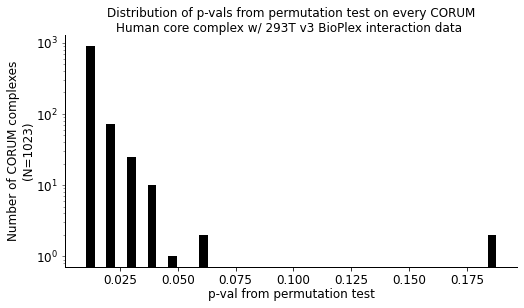

In [36]:
fig, ax = plt.subplots()

ax.hist(permutation_pvals_CORUM_complex_series, bins = 40, rwidth = 0.85, color = 'black')
ax.set_yscale('log')

ax.set_title('Distribution of p-vals from permutation test on every CORUM\nHuman core complex w/ 293T v3 BioPlex interaction data ', fontsize = 12, color = 'k', pad = -15)
ax.set_ylabel(f'Number of CORUM complexes\n(N={len(permutation_pvals_CORUM_complex_series)})', fontsize = 12, color = 'k', labelpad = 1)
ax.set_xlabel('p-val from permutation test' , fontsize = 12, color = 'k', labelpad = 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 4.5)
fig.tight_layout()

plt.show()

In [37]:
permutation_pvals_CORUM_complex_series.sort_values(ascending = True, inplace = True)
permutation_pvals_CORUM_complex_series.head()

12      0.009901
5545    0.009901
5546    0.009901
5550    0.009901
5551    0.009901
dtype: float64

In [38]:
permutation_pvals_CORUM_complex_series.tail()

6194    0.049505
5177    0.059406
814     0.059406
5615    0.188119
5613    0.188119
dtype: float64

If we want to Bonferroni correct this, we have to increase the number of permutations per test!

In [39]:
sum(permutation_pvals_CORUM_complex_series < (0.05/float(permutation_pvals_CORUM_complex_series.shape[0]))) # number of complexes with sig. pvals at Bonferroni cut-off

0

In [40]:
(0.05/float(permutation_pvals_CORUM_complex_series.shape[0])) < permutation_pvals_CORUM_complex_series.values[0]

True